# Aggregated Well Profiles

In [1]:
# load third-party Python modules
import javabridge
import bioformats as bf
import skimage
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import re
import os
import sys
import h5py
import json
from sklearn.manifold import TSNE

javabridge.start_vm(class_path=bf.JARS)

In [2]:
screenmap = pd.read_csv('../data/coculture_metafiles/screen_map.txt',
                            sep='\t')

In [3]:
with open('CLL-featselect.json') as file:
    featdict = json.load(file)
{k : len(v) for k,v in featdict.items()}

{'repcor': 194, 'residcor': 26}

In [4]:
feat_sel = ['well'] + featdict['residcor']

In [5]:
prof_dir = '../data/CLL_profiles/'

In [6]:
plates = os.listdir(prof_dir)

In [7]:
data_all = []
for plate in plates:
    imgdf = pd.read_csv(os.path.join(prof_dir, plate))
    X_subset = imgdf[feat_sel].copy()
    
    # load plate annotation table
    lt = screenmap[screenmap['plate']==plate.replace('.csv', '')]['lt'].values[0]
    layout_file = 'CLL_' + lt + '_layout.txt'
    annot_df = pd.read_csv(os.path.join('../data/coculture_metafiles', layout_file),
                           sep='\t')
    plate_df = pd.merge(X_subset, annot_df,on='well')
    mono = plate_df[plate_df['Culture']=='Mono-culture'].drop(['well', 'Culture', 'conc'], axis=1)
    co = plate_df[plate_df['Culture']=='Co-culture'].drop(['well', 'Culture', 'conc'], axis=1)

    mono = mono.groupby(['Drug'], as_index=False).agg('mean')
    co = co.groupby(['Drug'], as_index=False).agg('mean')

    plate_df = pd.merge(mono,co, on='Drug', how='inner')
    plate_df.index = plate_df['Drug']
    plate_df = plate_df.drop(['Drug'], axis=1)
    plate_df['plate'] = plate.replace('.csv', '')
    data_all.append(plate_df)

In [8]:
df_all = pd.concat(data_all)

In [9]:
df_wide = pd.pivot_table(df_all, index=df_all.index, columns='plate')

/Users/vlad/anaconda2/envs/ML/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



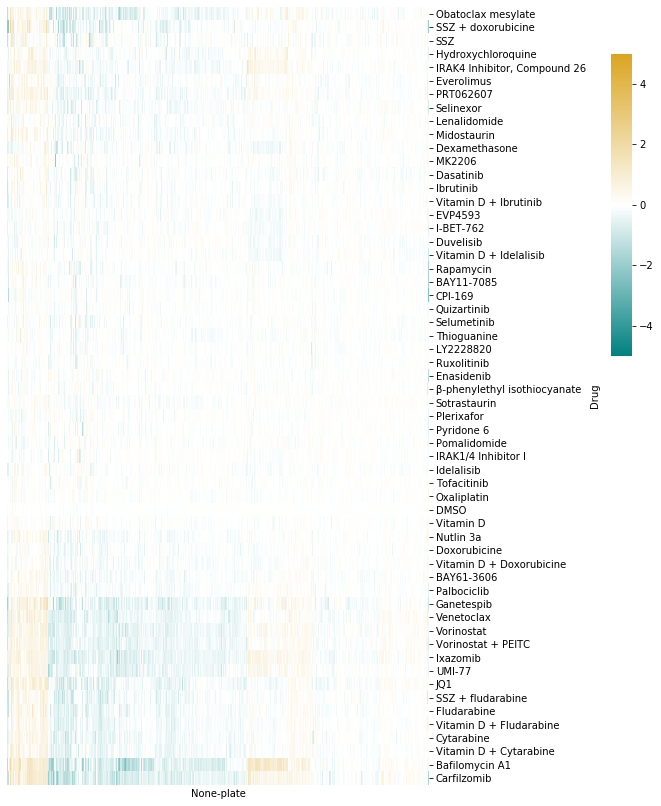

In [10]:
from bioimg.singlecell import plot_heatmap
plot_heatmap(df_wide, xticklabels=False, size=(10,14),
            yticklabels=True, vmin=-5, vmax=5)

Now include drug concentrations:

In [11]:
data_all = []
for plate in plates:
    imgdf = pd.read_csv(os.path.join(prof_dir, plate))
    X_subset = imgdf[feat_sel].copy()
    # load plate annotation table
    lt = screenmap[screenmap['plate']==plate.replace('.csv', '')]['lt'].values[0]
    layout_file = 'CLL_' + lt + '_layout.txt'
    annot_df = pd.read_csv(os.path.join('../data/coculture_metafiles', layout_file),
                           sep='\t')
    plate_df = pd.merge(X_subset, annot_df,on='well')
    plate_df['drugconc'] = plate_df['Drug']+"_"+plate_df['conc'].astype(str)
    mono = plate_df[plate_df['Culture']=='Mono-culture'].drop(['well', 'Culture', 'Drug', 'conc'], axis=1)
    co = plate_df[plate_df['Culture']=='Co-culture'].drop(['well', 'Culture', 'Drug', 'conc'], axis=1)

    mono = mono.groupby(['drugconc'], as_index=False).agg('mean')
    co = co.groupby(['drugconc'], as_index=False).agg('mean')

    plate_df = pd.merge(mono,co, on='drugconc', how='inner')
    plate_df.index = plate_df['drugconc']
    plate_df = plate_df.drop(['drugconc'], axis=1)
    plate_df['plate'] = plate.replace('.csv', '')
    data_all.append(plate_df)

In [12]:
df_all = pd.concat(data_all)

In [13]:
# don't replace NA values with zeros
# df_wide[df_wide.isna()] = 0

In [14]:
'''plot_heatmap(df_wide, xticklabels=False, size=(10,24),
            yticklabels=True, vmin=-5, vmax=5)'''

'plot_heatmap(df_wide, xticklabels=False, size=(10,24),\n            yticklabels=True, vmin=-5, vmax=5)'

In [15]:
data_all = []
for plate in plates:
    imgdf = pd.read_csv(os.path.join(prof_dir, plate))
    X_subset = imgdf[feat_sel].copy()
    # load plate annotation table
    lt = screenmap[screenmap['plate']==plate.replace('.csv', '')]['lt'].values[0]
    layout_file = 'CLL_' + lt + '_layout.txt'
    annot_df = pd.read_csv(os.path.join('../data/coculture_metafiles', layout_file),
                           sep='\t')
    plate_df = pd.merge(X_subset, annot_df,on='well')
    plate_df['drugconc'] = plate_df['Drug']+"_"+plate_df['conc'].astype(str)
    mono = plate_df[plate_df['Culture']=='Mono-culture'].drop(['well', 'Culture', 'Drug', 'conc'], axis=1)
    co = plate_df[plate_df['Culture']=='Co-culture'].drop(['well', 'Culture', 'Drug', 'conc'], axis=1)

    mono = mono.groupby(['drugconc'], as_index=False).agg('mean')
    mono.columns = mono.columns + "_M"
    co = co.groupby(['drugconc'], as_index=False).agg('mean')
    co.columns = co.columns + "_C"
    
    mono = mono.rename({"drugconc_M": "drugconc"}, axis=1)
    co = co.rename({"drugconc_C": "drugconc"}, axis=1)

    plate_df = pd.merge(mono,co, on='drugconc', how='inner')
    plate_df.index = plate_df['drugconc']
    plate_df = plate_df.drop(['drugconc'], axis=1)
    plate_df['plate'] = plate.replace('.csv', '')
    data_all.append(plate_df)

In [16]:
df_all = pd.concat(data_all)

In [17]:
df_wide = pd.pivot_table(df_all, index=df_all.index, columns='plate')
df_wide.columns = df_wide.columns.map('|'.join)

In [18]:
df_wide.to_csv('../data/all_CLL_profiles.csv')